## Installing Libraries needed for Quantum Machine Learning

This Tutorial depends on the code represented on the qiskit official website and the website can be accessed from here https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

In [46]:
%pip install qiskit
%pip install qiskit_machine_learning
%pip install imbalanced-learn
%pip install pylatexenc


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=c7f25ee0d9e8b25e7ec6e602611e2739f7b91cce7f8c35ae1fc3d602ad088c23
  Stored in directory: c:\users\varun\appdata\local\pip\cache\wheels\a3\68\66\2f15abd0673d83c02f354115feedeb89c3daed2ac319b11090
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.


#### Note : Restart the kernel after installing the required library to take those installations into effect

### Importing the libraries

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from sklearn.metrics import classification_report
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from typing import Union
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from imblearn.over_sampling import SMOTE
from IPython.display import clear_output

### Reading the dataset

The probem statement is to predict Milk quality on the basis of the input features. The dataset was taken from kaggle.

In [2]:
data=pd.read_csv("milknew.csv")

In [3]:
data.head(5)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


#### Getting the description and information about the dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [5]:
data.describe()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


The Task is to predict the Grade of the Milk.so Grade here is our target variable

In [6]:
data['Grade'].value_counts()

low       429
medium    374
high      256
Name: Grade, dtype: int64

#### Removing one category from target Variable

Here we are seeing the Taget variable is having three categories. Since this tutorial is concerned with the Implementation of Quantum Computing in Machine learning, we will deal with only Two categories of the target variable that is High and low.

For this we will remove all the data that is concerned with the target category as medium and after removing we will balance the class

In [7]:
df=data[(data['Grade']=='low')| (data['Grade']=='high')]

In [8]:
df['Grade'].value_counts()

low     429
high    256
Name: Grade, dtype: int64

#### Balancing the Categories

Since we have removed one category, the dataset got imbalanced. To omit the chances of overfitiing let's balance the dataset using SMOTE Algorithm

In [9]:
sm = SMOTE(random_state = 42)
X_oversampled, y_oversampled = sm.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
X = pd.DataFrame(X_oversampled, columns=df.iloc[:,:-1].columns)
Y = pd.DataFrame(y_oversampled, columns=[list(df.columns)[-1]])
df_balanced=pd.concat([X,Y],axis=1)

In [10]:
df_balanced['Grade'].value_counts()

high    429
low     429
Name: Grade, dtype: int64

In [11]:
df_balanced.head(5)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,1,1,1,1,255,high


In [12]:
df_balanced.shape

(858, 8)

###  Exploratory Data Analysis

#### Plotting the scatter plot between PH and Hued grouped by Taste

<AxesSubplot:xlabel='pH', ylabel='Temprature'>

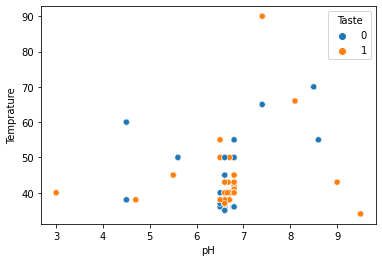

In [13]:
sns.scatterplot(data=df_balanced,x='pH',y='Temprature',hue='Taste')

#### Plotting the scatter plot between PH and Hued grouped by Odor

<AxesSubplot:xlabel='pH', ylabel='Temprature'>

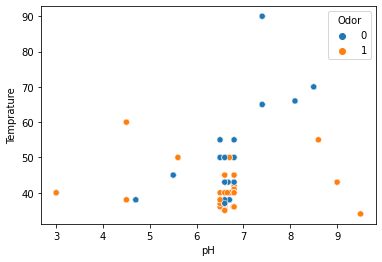

In [14]:
sns.scatterplot(data=df_balanced,x='pH',y='Temprature',hue='Odor')

<AxesSubplot:xlabel='pH', ylabel='Temprature'>

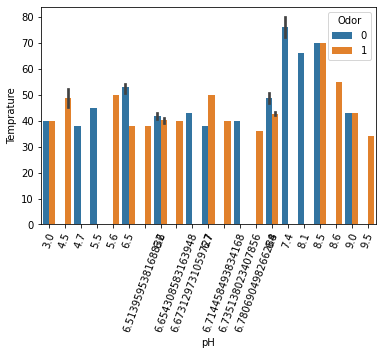

In [15]:

plt.xticks(rotation='70')
sns.barplot(data=df_balanced,x='pH',y='Temprature',hue='Odor')

### Label encoding the Target column

In [36]:
df_balanced['Grade']=df_balanced['Grade'].map({"high":1,"low":0})

### Splitting the Dataframe into Train and test

Splitting the Dataframe to Train and testfor training and validation Purposes. Also converting the splitted dataframes to numpy array as it will be needed while training the model

In [38]:
X_train,X_test,Y_train,Y_test=train_test_split(df_balanced.iloc[:,:-1],df_balanced.iloc[:,-1])
X_train=np.array(X_train)
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

### Classification with a CircuitQNN


Next we show how a CircuitQNN can be used for classification within a NeuralNetworkClassifier. In this context, the CircuitQNN is expected to return -dimensional probability vector as output, where  denotes the number of classes. Sampling from a QuantumCircuit automatically results in a probability distribution and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

Since we have number of input variables or features = 7, so we will use 7 qubits.

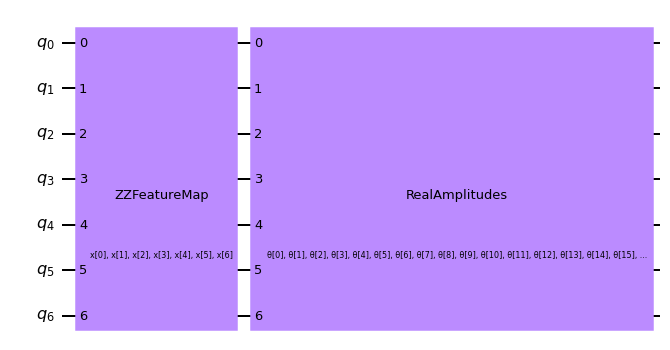

In [69]:
quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=100)
# construct feature map
num_inputs=df.iloc[:,:-1].shape[1]
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=2)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [70]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

#### callback function that draws a live plot when the .fit() method is called

In [53]:
 def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


#### construct QNN

In [71]:
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

In [72]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

Training on Simulators will take time and for the sake of it we have used only 100 rows of the data. If you have real QPUs you can run it on whole dataset

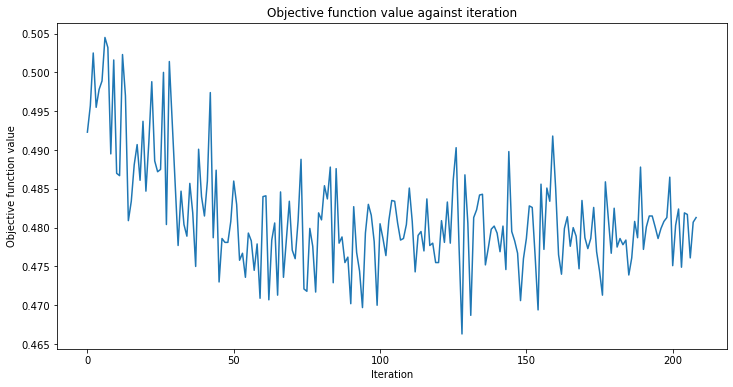

0.6314152410575428

In [84]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X_train[:100], Y_train[:100])

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(X_train, Y_train)


In [85]:
# evaluate data points
y_predict = circuit_classifier.predict(X_test)

In [88]:
print(classification_report(y_predict,Y_test))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       116
           1       0.61      0.70      0.65        99

    accuracy                           0.66       215
   macro avg       0.66      0.66      0.66       215
weighted avg       0.66      0.66      0.66       215



We have achieved the accuracy of 66%. Let's try to build VQC and see if there is any accuracy improvements

### Classification with Variational Quantum Classifier (VQC)


The VQC is a special variant of the NeuralNetworkClassifier with a CircuitQNN. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the CrossEntropyLoss function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [89]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

Since VQC takes Target variable in one hot encoded form, Let's convert our target variable into one hot encoded form

In [93]:
Y_one_hot=[]
for i in Y_train:
    if i==1:
        Y_one_hot.append([0,1])
    else:
        Y_one_hot.append([1,0])
Y_one_hot=np.array(Y_one_hot)

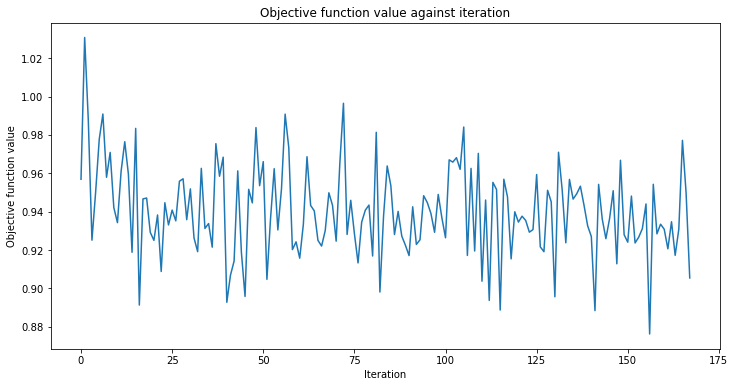

0.64

In [97]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train[0:50], Y_one_hot[0:50])

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train[0:50], Y_one_hot[0:50])

In [98]:
# evaluate data points
y_predict = vqc.predict(X_test)

In [109]:
y_pred=[]
for i in y_predict:
    if any(i==[1,0]):
        y_pred.append(0)
    else:
        y_pred.append(1)
         

In [112]:
print(classification_report(y_pred,Y_test))

              precision    recall  f1-score   support

           0       0.59      0.62      0.60        97
           1       0.67      0.64      0.66       118

    accuracy                           0.63       215
   macro avg       0.63      0.63      0.63       215
weighted avg       0.63      0.63      0.63       215

